## アニメーションを作ってみる

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [10]:
from IPython import display

In [5]:
import gymnasium as gym

In [6]:
import pygame

In [7]:
from pyvirtualdisplay import Display

In [8]:
d = Display()
d.start()

In [21]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
#env = gym.make("CartPole-v1")

In [31]:
o, info = env.reset(seed=42)
#env.render()
img = []

In [34]:
for _ in range(100):
    o, r, d, t, i = env.step(env.action_space.sample()) # 本当はDNNからアクションを入れる
    #出力はそれぞれ(observable, reward, done(termination), truncated(break the constraint), info)

    display.clear_output(wait=True)
    img.append(env.render())

    if d or t:
        if d:
            print('d')
        else:
            print('t')
        env.reset()

t


In [39]:
def make_anime(dpi, interval, img0):
    plt.figure(figsize=(img0[0].shape[1]/dpi,img0[0].shape[0]/dpi),dpi=dpi)
    patch = plt.imshow(img0[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(img0[i])
    ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img0),interval=interval)
    display.display(display.HTML(ani.to_jshtml()))

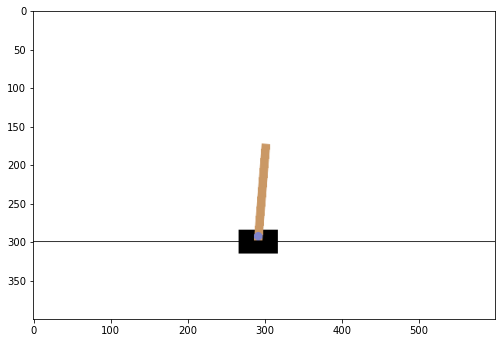

In [40]:
make_anime(72, 50, img)

In [42]:
s = [env.action_space.sample() for _ in range(10)]
print(s)

[0, 1, 0, 0, 1, 0, 1, 0, 0, 0]


In [44]:
print(o)

[-0.05827197 -0.9616463   0.08483153  1.6098078 ]


In [45]:
from casadi import *

In [46]:
class CP_env:
    def __init__(self):
        self.mc = 2.0   # cart の質量[kg]
        self.mp = 0.2   # pole の質量[kg]
        self.l = 0.5    # pole の長さ[m]
        self.g = 9.81   # 重力加速度[m/s2]

    def dynamics(self, x, u):
        mc = self.mc
        mp = self.mp
        l = self.l
        g = self.g
        y = x[0]     # cart の水平位置[m]
        th = x[1]    # pole の傾き角[rad]
        dy = x[2]    # cart の水平速度[m/s]
        dth = x[3]   # pole の傾き角速度[rad/s]
        f = u[0]     # cart を押す力[N]（制御入力）
        # cart の水平加速度
        ddy = (f+mp*np.sin(th)*(l*dth*dth+g*np.cos(th))) / (mc+mp*np.sin(th)*np.sin(th)) 
        # pole の傾き角加速度
        ddth = (-f*np.cos(th)-mp*l*dth*dth*np.cos(th)*np.sin(th)-(mc+mp)*g*np.sin(th)) / (l * (mc+mp*np.sin(th)*np.sin(th))) 
        return dy, dth, ddy, ddth

In [47]:
class CostFunction:
    def __init__(self):
        self.nx = 4
        self.nu = 1
        self.x_ref = [0.0, np.pi, 0.0, 0.0]   # 目標状態
        # ステージコストのパラメータ 
        self.Q  = [2.5, 10.0, 0.01, 0.01]       # 状態への重み
        self.R  = [0.1]                         # 制御入力への重み
        # 終端コストのパラメータ 
        self.Qf = [2.5, 10.0, 0.01, 0.01]       # 状態への重み

    # ステージコスト
    def stage_cost(self, x, u):
        l = 0                             
        for i in range(self.nx):
            l += 0.5 * self.Q[i] * (x[i]-self.x_ref[i])**2 
        for i in range(self.nu):
            l += 0.5 * self.R[i] * u[i]**2
        return l

    # 終端コスト
    def terminal_cost(self, x):
        Vf = 0
        for i in range(self.nx):
            Vf += 0.5 * self.Q[i] * (x[i]-self.x_ref[i])**2 
        return Vf

In [48]:
# 問題設定
T = 5.0     # ホライゾン長さ
N = 100      # ホライゾン離散化グリッド数
dt = T / N  # 離散化ステップ
nx = 4      # 状態空間の次元
nu = 1      # 制御入力の次元

# 以下で非線形計画問題(NLP)を定式化
w = []    # 最適化変数を格納する list
w0 = []   # 最適化変数(w)の初期推定解を格納する list
lbw = []  # 最適化変数(w)の lower bound を格納する list
ubw = []  # 最適化変数(w)の upper bound を格納する list
g = []    # 制約（等式制約，不等式制約どちらも）を格納する list
lbg = []  # 制約関数(g)の lower bound を格納する list
ubg = []  # 制約関数(g)の upper bound を格納する list
J = 0     # 評価関数 

In [49]:
Xk = MX.sym('X0', nx) # 初期時刻の状態ベクトル x0
w += [Xk]             # x0 を 最適化変数 list (w) に追加
# 初期状態は given という条件を等式制約として考慮
lbw += [0., 0., 0., 0.]  # 等式制約は lower-bound と upper-bound を同じ値にすることで設定
ubw += [0, 0, 0, 0]  # 等式制約は lower-bound と upper-bound を同じ値にすることで設定
w0 +=  [0, 0, 0, 0]  # x0 の初期推定解

In [50]:
print(w0)

[0, 0, 0, 0]


In [51]:
cp = CP_env()
cost = CostFunction()

In [52]:
# 離散化ステージ k=0~N-1 までのステージコストと制約を設定
for k in range(N):
    Uk = MX.sym('U_' + str(k), nu) # 時間ステージ k の制御入力 uk を表す変数
    w   += [Uk]                    # uk を最適化変数 list に追加
    lbw += [-5.0]                # uk の lower-bound
    ubw += [5.0]                # uk の upper-bound
    w0  += [0]                    # uk の初期推定解

    # コスト関数にステージコスト l(x_k, u_k) を追加
    J = J + cost.stage_cost(Xk, Uk) * dt                    

    # Forward Euler による離散化状態方程式
    dXk = cp.dynamics(Xk, Uk) # xdot＝f(x, u)
    Xk_next = vertcat(Xk[0] + dXk[0] * dt, 
                                     Xk[1] + dXk[1] * dt,
                                     Xk[2] + dXk[2] * dt,
                                     Xk[3] + dXk[3] * dt)
    Xk1 = MX.sym('X_' + str(k+1), nx)  # 時間ステージ k+1 の状態 xk+1 を表す変数
    w   += [Xk1]                       # xk+1 を最適化変数 list に追加
    lbw += [-10., -inf, -inf, -inf]    # xk+1 の lower-bound （指定しない要素は -inf）
    ubw += [10., inf, inf, inf]        # xk+1 の upper-bound （指定しない要素は inf）
    w0 += [0.0, 0.0, 0.0, 0.0]         # xk+1 の初期推定解

    # 状態方程式(xk+1=xk+fk*dt) を等式制約として導入
    g   += [Xk_next-Xk1]
    lbg += [0, 0, 0, 0] # 等式制約は lower-bound と upper-bound を同じ値にすることで設定
    ubg += [0, 0, 0, 0] # 等式制約は lower-bound と upper-bound を同じ値にすることで設定
    Xk = Xk1

In [53]:
J = J + cost.terminal_cost(Xk)

In [54]:
# 非線形計画問題(NLP)
nlp = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)} 
# Ipopt ソルバー，最小バリアパラメータを0.001に設定
solver = nlpsol('solver', 'ipopt', nlp, {'ipopt':{'mu_min':0.001}}) 
# SQP ソルバー（QPソルバーはqpOASESを使用），QPソルバーの regularization 無効，QPソルバーのプリント無効
# solver = nlpsol('solver', 'sqpmethod', nlp, {'max_iter':100, 'qpsol_options':{'enableRegularisation':False, 'printLevel':None}})

In [55]:
# NLPを解く
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     1491
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      698

Total number of variables............................:      500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:      400
Total number of inequality c

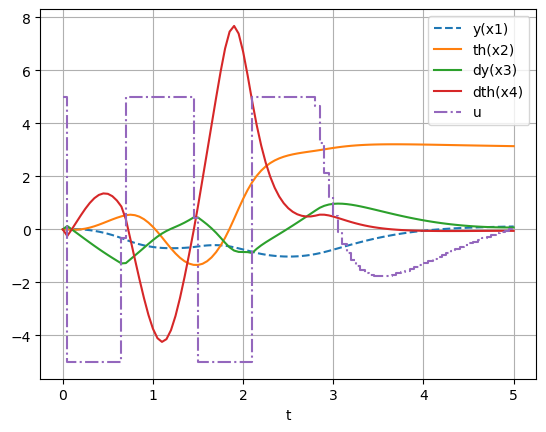

In [56]:
w_opt = sol['x'].full().flatten() # full()でndarrayに変換(行列系)、flattenでベクトルに変換

# 解をプロット
x1_opt = w_opt[0::5]#0から5飛ばしで要素を取得
x2_opt = w_opt[1::5]
x3_opt = w_opt[2::5]
x4_opt = w_opt[3::5]
u_opt  = w_opt[4::5]

tgrid = [dt*k for k in range(N+1)]
import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()
plt.plot(tgrid, x1_opt, '--')
plt.plot(tgrid, x2_opt, '-')
plt.plot(tgrid, x3_opt, '-')
plt.plot(tgrid, x4_opt, '-')
plt.step(tgrid, np.concatenate([np.array([np.nan]), u_opt]), '-.')
plt.xlabel('t')
plt.legend(['y(x1)','th(x2)', 'dy(x3)', 'dth(x4)','u'])
plt.grid()
plt.show()

In [68]:
test = sol['x']
print(type(test))
print(np.shape(test.full()))
print(np.shape(test.full().flatten()))

<class 'casadi.casadi.DM'>
(504, 1)
(504,)


In [69]:
class MPC:
    def __init__(self):
        # 問題設定
        T = 1.0     # ホライゾン長さ (MPCなので短め)
        N = 20      # ホライゾン離散化グリッド数 (MPCなので荒め)
        dt = T / N  # 離散化ステップ
        nx = 4      # 状態空間の次元
        nu = 1      # 制御入力の次元
        cartpole = CP_env() # cartpole のダイナミクス
        cost_function = CostFunction() # コスト関数

        # 以下で非線形計画問題(NLP)を定式化
        w = []    # 最適化変数を格納する list
        w0 = []   # 最適化変数(w)の初期推定解を格納する list
        lbw = []  # 最適化変数(w)の lower bound を格納する list
        ubw = []  # 最適化変数(w)の upper bound を格納する list
        J = 0     # コスト関数 
        g = []    # 制約（等式制約，不等式制約どちらも）を格納する list
        lbg = []  # 制約関数(g)の lower bound を格納する list
        ubg = []  # 制約関数(g)の upper bound を格納する list
        lam_x0 = []  # 制約 lbw<w<ubw のラグランジュ乗数
        lam_g0 = []  # 制約 lbg<g<ubg のラグランジュ乗数

        Xk = MX.sym('X0', nx) # 初期時刻の状態ベクトル x0
        w += [Xk]             # x0 を 最適化変数 list (w) に追加
        # 初期状態は given という条件を等式制約として考慮
        lbw += [0, 0, 0, 0]  # 等式制約は lower-bound と upper-bound を同じ値にすることで設定
        ubw += [0, 0, 0, 0]      # 等式制約は lower-bound と upper-bound を同じ値にすることで設定
        w0 +=  [0, 0, 0, 0]      # x0 の初期推定解
        lam_x0 += [0, 0, 0, 0]    # ラグランジュ乗数の初期推定解

        # 離散化ステージ 0~N-1 までのコストと制約を設定
        for k in range(N):
            Uk = MX.sym('U_' + str(k), nu) # 時間ステージ k の制御入力 uk を表す変数
            w   += [Uk]                   # uk を最適化変数 list に追加
            lbw += [-15.0]                # uk の lower-bound
            ubw += [15.0]                 # uk の upper-bound
            w0  += [0]                    # uk の初期推定解
            lam_x0 += [0]                 # ラグランジュ乗数の初期推定解

            # ステージコスト
            J = J + dt * cost_function.stage_cost(Xk, Uk) # コスト関数にステージコストを追加

            # Forward Euler による離散化状態方程式
            dXk = cartpole.dynamics(Xk, Uk)
            Xk_next = vertcat(Xk[0] + dXk[0] * dt, 
                              Xk[1] + dXk[1] * dt,
                              Xk[2] + dXk[2] * dt,
                              Xk[3] + dXk[3] * dt)
            Xk1 = MX.sym('X_' + str(k+1), nx)  # 時間ステージ k+1 の状態 xk+1 を表す変数
            w   += [Xk1]                       # xk+1 を最適化変数 list に追加
            lbw += [-inf, -inf, -inf, -inf]    # xk+1 の lower-bound （指定しない要素は -inf）
            ubw += [inf, inf, inf, inf]        # xk+1 の upper-bound （指定しない要素は inf）
            w0 += [0.0, 0.0, 0.0, 0.0]         # xk+1 の初期推定解
            lam_x0 += [0, 0, 0, 0]              # ラグランジュ乗数の初期推定解

            # 状態方程式(xk+1=xk+fk*dt) を等式制約として導入
            g   += [Xk_next-Xk1]
            lbg += [0, 0, 0, 0]     # 等式制約は lower-bound と upper-bound を同じ値にすることで設定
            ubg += [0, 0, 0, 0]     # 等式制約は lower-bound と upper-bound を同じ値にすることで設定
            lam_g0 += [0, 0, 0, 0]   # ラグランジュ乗数の初期推定解
            Xk = Xk1

        # 終端コスト 
        J = J + cost_function.terminal_cost(Xk) # コスト関数に終端コストを追加

        self.J = J
        self.w = vertcat(*w)
        self.g = vertcat(*g)
        self.x = w0
        self.lam_x = lam_x0
        self.lam_g = lam_g0
        self.lbx = lbw
        self.ubx = ubw
        self.lbg = lbg
        self.ubg = ubg

        # 非線形計画問題(NLP)
        self.nlp = {'f': self.J, 'x': self.w, 'g': self.g} 
        # Ipopt ソルバー，最小バリアパラメータを0.1，最大反復回数を5, ウォームスタートをONに
        self.solver = nlpsol('solver', 'ipopt', self.nlp, {'calc_lam_p':True, 'calc_lam_x':True, 'print_time':False, 'ipopt':{'max_iter':5, 'mu_min':0.1, 'warm_start_init_point':'yes', 'print_level':0, 'print_timing_statistics':'no'}}) 
        # self.solver = nlpsol('solver', 'scpgen', self.nlp, {'calc_lam_p':True, 'calc_lam_x':True, 'qpsol':'qpoases', 'print_time':False, 'print_header':False, 'max_iter':5, 'hessian_approximation':'gauss-newton', 'qpsol_options':{'print_out':False, 'printLevel':'none'}}) # print をオフにしたいがやり方がわからない


    def init(self, x0=None):
        if x0 is not None:
            # 初期状態についての制約を設定
            self.lbx[0:4] = x0
            self.ubx[0:4] = x0
        # primal variables (x) と dual variables（ラグランジュ乗数）の初期推定解も与えつつ solve（warm start）
        sol = self.solver(x0=self.x, lbx=self.lbx, ubx=self.ubx, lbg=self.lbg, ubg=self.ubg, lam_x0=self.lam_x, lam_g0=self.lam_g)
        # 次の warm start のために解を保存
        self.x = sol['x'].full().flatten()
        self.lam_x = sol['lam_x'].full().flatten()
        self.lam_g = sol['lam_g'].full().flatten()

    def solve(self, x0):
        # 初期状態についての制約を設定
        nx = x0.shape[0]
        self.lbx[0:nx] = x0
        self.ubx[0:nx] = x0
        # primal variables (x) と dual variables（ラグランジュ乗数）の初期推定解も与えつつ solve（warm start）
        sol = self.solver(x0=self.x, lbx=self.lbx, ubx=self.ubx, lbg=self.lbg, ubg=self.ubg, lam_x0=self.lam_x, lam_g0=self.lam_g)
        # 次の warm start のために解を保存
        self.x = sol['x'].full().flatten()
        self.lam_x = sol['lam_x'].full().flatten()
        self.lam_g = sol['lam_g'].full().flatten()
        return np.array([self.x[4]]) # 制御入力を return

t = 0.0
t = 1.0
t = 2.0
t = 3.0
t = 4.0
t = 5.0
t = 6.0
t = 7.0
t = 8.0
t = 9.0


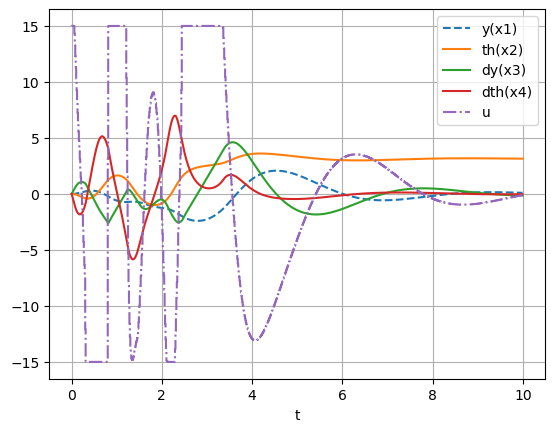

In [71]:
import math
sim_time = 10.0 # 10秒間のシミュレーション
sampling_time = 0.01 # 0.01秒（10ms）のサンプリング周期
sim_steps = math.floor(sim_time/sampling_time)
xs = []
us = []
cartpole = CP_env()
mpc = MPC()
mpc.init()
x = np.zeros(4)
for step in range(sim_steps):
    if step%(1/sampling_time)==0:
        print('t =', step*sampling_time)
    u = mpc.solve(x)
    xs.append(x)
    us.append(u)
    x1 = x + sampling_time * np.array(cartpole.dynamics(x, u))
    x = x1

# シミュレーション結果をプロット
xs1 = [x[0] for x in xs]
xs2 = [x[1] for x in xs]
xs3 = [x[2] for x in xs]
xs4 = [x[3] for x in xs]
tgrid = [sampling_time*k for k in range(sim_steps)]

import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()
plt.plot(tgrid, xs1, '--')
plt.plot(tgrid, xs2, '-')
plt.plot(tgrid, xs3, '-')
plt.plot(tgrid, xs4, '-')
plt.step(tgrid, us, '-.')
plt.xlabel('t')
plt.legend(['y(x1)','th(x2)', 'dy(x3)', 'dth(x4)','u'])
plt.grid()
plt.show()

In [72]:
l = 5
list_test = np.array([1]*int(l) + [2]*int(l) + [3]*int(l) + [4]*int(l)*2 + [3]*int(l) + [2]*int(l) + [1]*int(l)+ [0]*int(l) + [-1]*int(l*3))
print(list_test)

[ 1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  4  4  4  4
  4  3  3  3  3  3  2  2  2  2  2  1  1  1  1  1  0  0  0  0  0 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [74]:
print(np.abs([1]*int(3)))

[1 1 1]
